In [ ]:
company_output = 'PETR4.SA'
end_date = '2024-11-15' 
start_date = '2024-06-01'
stock_var = 'Adj Close'
company_inputs = 'PETR4.SA'

seq_length = 30
batch_size = 30

In [260]:
import mlflow
import mlflow.sklearn

scalerX_path = 'artifacts/transformers/scalerX'
scalery_path = 'artifacts/transformers/scalery'
model_path = 'artifacts/models_tf/best_models'

scalerX = mlflow.sklearn.load_model(scalerX_path)
scalery = mlflow.sklearn.load_model(scalery_path)
model = mlflow.sklearn.load_model(model_path)

In [261]:
from feature_engineering import get_finance_df
from feature_engineering import split_train_test_valid_df, shift_drop_na_in_xy

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

df = get_finance_df(company_inputs, start_date, end_date, stock_var)

X, y = shift_drop_na_in_xy(df, company_inputs, company_output, horizon_pred=1)

N_days = len(df) - seq_length
print(N_days)

[*********************100%***********************]  1 of 1 completed

69


In [262]:
# Normalize the Price column
scaled_X = scalerX.transform(X.reshape(-1, 1))
scaled_y = scalery.transform(y.reshape(-1, 1))

# Initialize generator with multivariable input and single target
generator = TimeseriesGenerator(scaled_X, scaled_y, length=seq_length, batch_size=batch_size)

In [263]:
import numpy as np

y_pred = np.array([])
y_valid = np.array([])
G = len(generator)
for k in range(G):
    X_gen, y_gen = generator[k]
    y_pred_scaled = model.predict(X_gen)

    y_pred = np.append(y_pred, scalery.inverse_transform(y_pred_scaled.reshape(-1,1)))
    y_valid = np.append(y_valid, scalery.inverse_transform(y_gen.reshape(-1,1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


In [264]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Calculate RMSE and R² score
rmse = root_mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print([ f"R2={r2}", f"RMSE={rmse}"])

['R2=-0.039927068030800594', 'RMSE=1.0682622386160976']


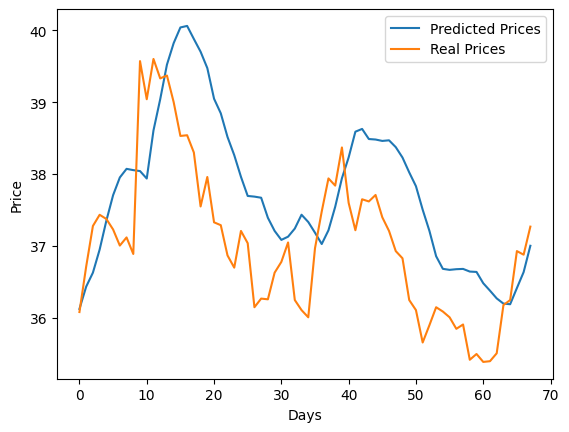

In [265]:
import matplotlib.pyplot as plt

# Plot the predicted prices\n"
plt.plot(y_pred, label="Predicted Prices")
plt.plot(y_valid, label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()